# Grey-box identification of heat transfer dynamics

Last update: 27-07-2023

---

The primary goal of this project is to identify convection effects in a grey-box model of heat transfer dynamics (see system description below), based on temperature measurements throughout the rod.

In [1]:
import Pkg
Pkg.activate("..")
Pkg.instantiate()

  Activating project at `~/syndr/Wouter/Onderzoek/Projecten/sioux/sysid-thermal/CCTA2024-BIDconvection`


## System description

A schematic depiction of the setup is shown in the figure below. 

<p><center><img src='../../system/system-photo.png'/></center></p>

In short, the setup consists of 3 metal blocks which have been lined up, with resistive nylon pads interposed. The temperature can be measured using thermistors at arbitrary places on the setup; for simplicity we assume that we measure the temperature at a single spot on each block, which we call $\tau_1$, $\tau_2$, and $\tau_3$. The temperatures will evolve due to a number of different factors; we will only consider the influence of conduction, convection, radiation, and the user controlled input heat (band heaters).

By assuming that conduction within blocks is so fast that there are no temperature differences within a block, we may model the system using a [lumped-element model](https://en.wikipedia.org/wiki/Lumped-element_model), governed by the following system of ODEs:

$$\frac{d}{dt}\begin{pmatrix} m_1 c_{p, 1} \tau_1 \\ m_2 c_{p, 2} \tau_2 \\ m_3 c_{p, 3} \tau_3 \end{pmatrix} = 
\underbrace{\begin{pmatrix} -k_{12} & k_{12} & 0 \\ k_{12} & -(k_{12} + k_{23}) & k_{23} \\ 0 & k_{23} & -k_{23} \end{pmatrix} \begin{pmatrix} \tau_1 \\ \tau_2 \\ \tau_3 \end{pmatrix}}_{\textrm{conduction}} + \underbrace{\begin{pmatrix} h(\tau_1, \tau_a, 1, t) \\ h(\tau_2, \tau_a, 2, t) \\ h(\tau_3, \tau_a, 3, t) \end{pmatrix}}_{\textrm{convection}} + \underbrace{\sigma \begin{pmatrix} a_1 \varepsilon_1 (\tau_a^4 - \tau_1^4) \\ a_2 \varepsilon_2 (\tau_a^4 - \tau_2^4) \\ a_3 \varepsilon_3 (\tau_a^4 - \tau_3^4) \end{pmatrix}}_{\textrm{radiation}} + \underbrace{\begin{pmatrix} u_1 \\ u_2 \\ u_3 \end{pmatrix}}_{\textrm{input}}.$$

Convection is notoriously hard to model. A coarse approximation would be Newton's law of cooling (Clercx, 2015; Eq. 8.17), which states that convection is linear in the difference between the temperature of the block and the ambient temperature: $h_a (\tau_a - \tau_i)$. With this linear term, we can take steps similar to the identification of the oscillator in Rogers \& Friis (2022), describing the nonlinear function as the combination of a linear term and a "nonlinear remainder":

$$\underbrace{h(\tau_i, \tau_a, i, t)}_{\text{total convection}} = \underbrace{h_a (\tau_a - \tau_i)}_{\text{linear cooling law}} + \underbrace{r(\tau_i, \tau_a, i, t)}_{\text{nonlinear remainder}} \, ,$$

for some constant $h_a$. Furthermore, the role of radiation can often be neglected. With these simplifications, our governing equations become:

$$\frac{d}{dt}\begin{pmatrix} m_1 c_{p, 1} \tau_1 \\ m_2 c_{p, 2} \tau_2 \\ m_3 c_{p, 3} \tau_3 \end{pmatrix} = 
\begin{pmatrix} -k_{12} & k_{12} & 0 \\ k_{12} & -(k_{12} + k_{23}) & k_{23} \\ 0 & k_{23} & -k_{23} \end{pmatrix} \begin{pmatrix} \tau_1 \\ \tau_2 \\ \tau_3 \end{pmatrix} + h_a \begin{pmatrix} a_1 (\tau_a - \tau_1) \\ a_2 (\tau_a - \tau_2) \\ a_3 (\tau_a - \tau_3) \end{pmatrix} + \begin{pmatrix} r(\tau_1, \tau_a, 1, t) \\ r(\tau_2, \tau_a, 2, t) \\ r(\tau_3, \tau_a, 3, t) \end{pmatrix} + \begin{pmatrix} u_1 \\ u_2 \\ u_3 \end{pmatrix},$$

or, more compactly, 

$$ M \dot{z} = K z + h_a a (\tau_a - z) + r(z,\tau_a) + u$$

where $z = [\tau_1 \, , \ \tau_2 \, , \ \tau_3]$.

In these equations, we can distinguish three types of quantities:
1. Measured/observed quantities: e.g. $\tau_i$, $u_i$. These may vary over time, and are known up to a given accuracy due to measurement noise;

2. Known constants: e.g. $m_i$, $c_{p, i}$, $a$, $\tau_a$. These are fully known, and are constant over time. This is reasonable for quantities such as mass $m$ and surface area $a$ (which can be easily measured) and specific heat capacity $c_p$ (which is a material property which according to the Dulong-Petit Law is roughly constant for metals over a long range of temperatures Carter (2000), Ch. 16) Maybe it is less reasonable for the ambient temperature $\tau_a$ (due to e.g. the setup heating up its surroundings);

3. Unknown constants: e.g. $k_{ij}$, $h_a$. These are not known a priori, because there is no simple physical way to measure or derive their values. For example, the conduction coefficients $k_{ij}$ can vary depending on how tightly the blocks have been put together. In this project, we want to identify these constants using Bayesian inference.

In [2]:
using Revise
using DifferentialEquations
using Distributions
using ForwardDiff
using LaTeXStrings
using LinearAlgebra
using MAT
using Optim
using Polynomials
using Random
using RxInfer

using Plots; default(label="", linewidth=3, margin=15Plots.pt)
include("../util/discretization.jl");

## Data simulation

In [3]:
# Time parameters
T = 600
Δt = 0.1
tsteps = range(0.0, step=Δt, length=T)

# Constants
true_mcp_1 = 1e3
true_mcp_2 = 1e3
true_mcp_3 = 1e3
true_a_1 = 1.0
true_a_2 = 1.0
true_a_3 = 1.0
true_k12 = 100.
true_k23 = 50.
true_h_a = 10.0
true_τ_a = 21.
true_R   = 1e-2*diagm(ones(3))

# Input heat parameters
true_b = [3000.0, 0., 0.]

3-element Vector{Float64}:
 3000.0
    0.0
    0.0

In [4]:
# Temperature inputs
τr = range(10, stop=40, step=0.1)
NN = length(τr)

# Kernel hyperparameters
λ_true = 1e-3
γ_true = 1e5

# Kernel
κ(τ,τ_prime) = γ_true.*exp.(-λ_true.*abs.(τ - τ_prime))
K = zeros(NN,NN)
for ii in 1:NN
    for jj in 1:NN
        K[ii,jj] = κ(τr[ii], τr[jj])
    end
end

# Inverse of kernel
Ki = inv(K + 1e-10diagm(ones(NN)))

# Generate targets for Gaussian Process
r(z,i,τ_a) = min(0,((τ_a - (10-2i) -z[1])^3)./2)
# r(z,i,τ_a) = min(0,((τ_a - z)^3)./i)
targets1 = r.(τr, 1, true_τ_a) 
targets2 = r.(τr, 2, true_τ_a) 
targets3 = r.(τr, 3, true_τ_a) 

# GP Predictive distribution
pred_mean_block1(τ) = dot(κ.(τ,τr), Ki*targets1)
pred_mean_block2(τ) = dot(κ.(τ,τr), Ki*targets2)
pred_mean_block3(τ) = dot(κ.(τ,τr), Ki*targets3)

pred_mean_block3 (generic function with 1 method)

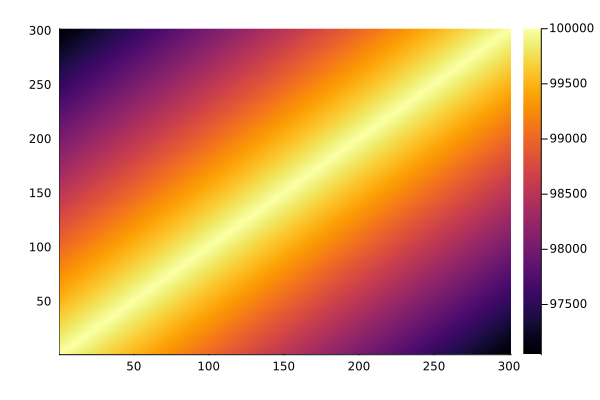

In [5]:
heatmap(K)

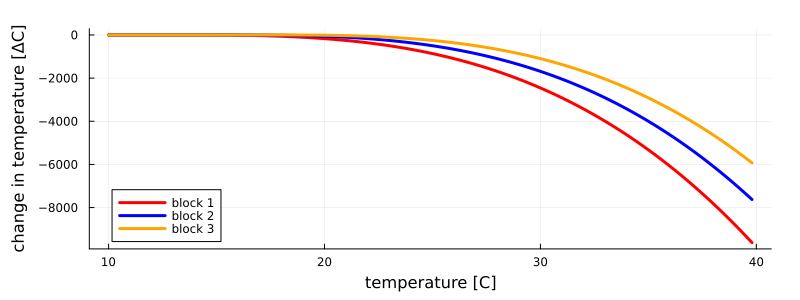

In [6]:
# Simulate nonlinear convection function
dτr1 = pred_mean_block1.(τr)
dτr2 = pred_mean_block2.(τr)
dτr3 = pred_mean_block3.(τr)

plot(xlabel="temperature [C]", ylabel="change in temperature [ΔC]", size=(800,300))
plot!(τr[1:end-2], dτr1[1:end-2], color="red", label="block 1")
plot!(τr[1:end-2], dτr2[1:end-2], color="blue", label="block 2")
plot!(τr[1:end-2], dτr3[1:end-2], color="orange", label="block 3")

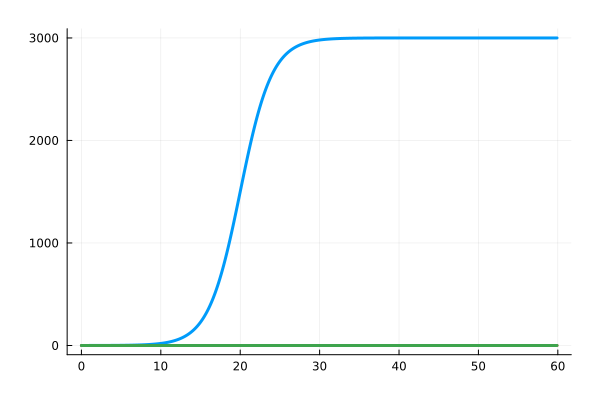

In [7]:
function u(t::Float64, b::Float64; i::Int64=1) 
    "Constant heater"
    return b
end

function u(t::Float64, b::Float64, t_on::Float64; i::Int64=1, β::Float64=0.1) 
    "Turn on heater"
    return b ./(1+exp(-β*(t - t_on))) 
end

function u(t::Float64; i::Int64=1, b::Float64=1.0, t_on::Float64=20., t_off::Float64=60., β1::Float64=0.6, β2::Float64=0.4) 
    "Pulse heater"
    return b ./(1+exp(-β1*(t - t_on))) * exp(-β2*(t - t_off))./(1+exp(-β2*(t - t_off)))
end

t_onset = 20.
β = 0.5

# Generate functions
u1(t) = u.(t, true_b[1], t_onset, i=1, β=β)
u2(t) = u.(t, true_b[2], t_onset, i=2, β=β)
u3(t) = u.(t, true_b[3], t_onset, i=3, β=β)

inputs = hcat([[u1(k); u2(k); u3(k)] for k in tsteps]...)

plot(tsteps, inputs')

In [8]:
function NONLCONV(dz, z, params, t)
    "Lumped-element model with nonlinear convection term"

    # Extract parameters
    mcp_1, mcp_2, mcp_3, a_1, a_2, a_3, τ_a, k12, k23, h_a = params
    
    # Conduction
    dz[1] = (-k12*z[1] +      k12 *z[2]            ) / mcp_1
    dz[2] = ( k12*z[1] - (k12+k23)*z[2] + k23 *z[3]) / mcp_2
    dz[3] = (                 k23 *z[2] - k23 *z[3]) / mcp_3
    
    # Convection - linear
    dz[1] += h_a * a_1 * (τ_a - z[1]) / mcp_1
    dz[2] += h_a * a_2 * (τ_a - z[2]) / mcp_2
    dz[3] += h_a * a_3 * (τ_a - z[3]) / mcp_3 
    
    # Convection - nonlinear
    dz[1] += pred_mean_block1(z[1]) / mcp_1
    dz[2] += pred_mean_block2(z[2]) / mcp_2
    dz[3] += pred_mean_block3(z[3]) / mcp_3
    
    # Input heat
    dz[1] += u1(t) / mcp_1
    dz[2] += u2(t) / mcp_2
    dz[3] += u3(t) / mcp_3
end

NONLCONV (generic function with 1 method)

In [9]:
sysparams = [true_mcp_1, 
             true_mcp_2, 
             true_mcp_3, 
             true_a_1, 
             true_a_2, 
             true_a_3,
             true_τ_a, 
             true_k12, 
             true_k23, 
             true_h_a]

τ_0 = [21., 21., 21.]

# Solve the system numerically using DifferentialEquations.jl
sys_NONLCONV = ODEProblem(NONLCONV, τ_0, (tsteps[1], tsteps[end]), sysparams)
states = Array(solve(sys_NONLCONV, RK4(); saveat=tsteps, verbose = true))

3×600 Matrix{Float64}:
 21.0  20.9746  20.9496  20.9251  …  29.7871  29.7872  29.7873  29.7874
 21.0  20.9892  20.9783  20.9674     24.3303  24.3307  24.3312  24.3316
 21.0  20.9968  20.9935  20.9903     22.2909  22.2924  22.2938  22.2953

In [10]:
# Noisy measurements
measurements = zeros(3,T)
for k = 1:T
    measurements[:,k] = states[:,k] + cholesky(true_R).L*randn(3)
end

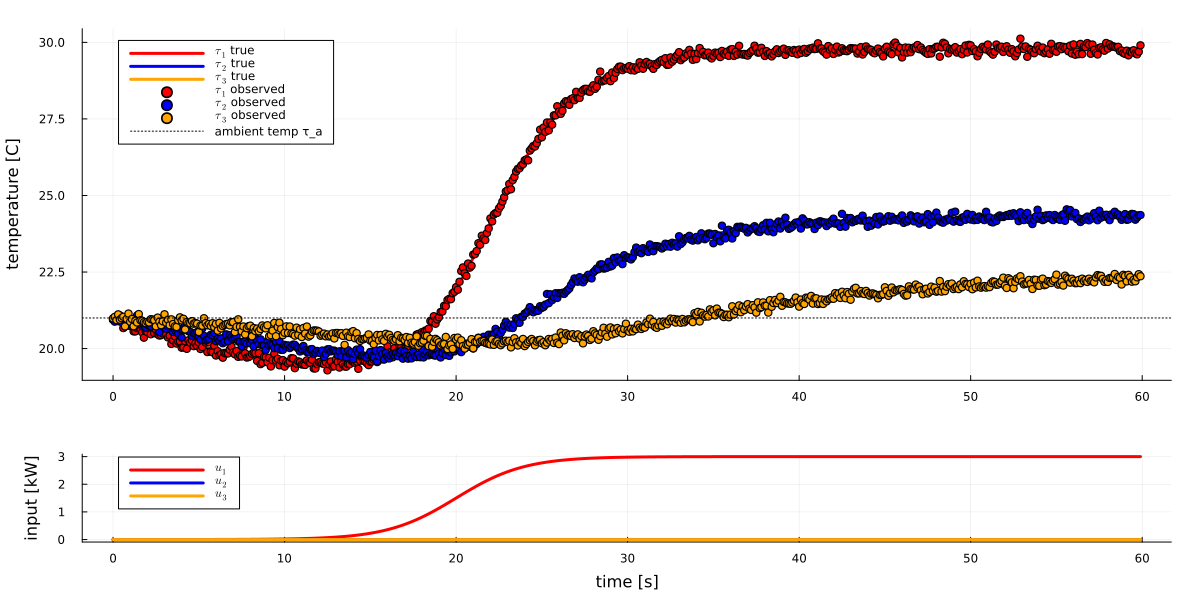

In [11]:
p101 = plot(xlabel="", ylabel="temperature [C]")
plot!(tsteps, states', linecolors = ["red" "blue" "orange"], labels = [L"$τ_1$ true" L"$τ_2$ true" L"$τ_3$ true"], )
scatter!(tsteps, measurements', markercolors = ["red" "blue" "orange"], labels = [L"$τ_1$ observed" L"$τ_2$ observed" L"$τ_3$ observed"])
hline!([true_τ_a], color="black", linewidth=1, linestyle=:dot, label="ambient temp τ_a")

p102 = plot(xlabel = "time [s]", ylabel = "input [kW]")
plot!(tsteps, inputs' ./ 1000, linecolors = ["red" "blue" "orange"], labels = [L"$u_1$" L"$u_2$" L"$u_3$"], )

plot(p101, p102, layout=grid(2,1, heights=[0.8, 0.2]), size=(1200,600))

In [12]:
output_ = [measurements[:,k] for k in 1:T];
inputs_ = [[true_τ_a; inputs[:,k]] for k in 1:T];

## GP-augmented state-space model

### Matern-1/2 GP in state-space form
Suppose a function $h(x)$ follows a zero-mean Gaussian Process

$$\begin{aligned}
h(x) \sim \mathcal{GP}(0, k(x,x')) \, .
\end{aligned}$$

The GP can be written as the following differential equation ([Hartikainen, 2013)](https://aaltodoc.aalto.fi/bitstream/handle/123456789/7579/isbn9789526049847.pdf?sequence=1&isAllowed=y)):

$$\begin{align}
\dot{h} = F_h h + L v \, ,
\end{align}$$

with $h$ being states, $F_h$ a state transition matrix and $v$ a white noise process. The Matern GP has a stationary covariance function, defined as:

$$\begin{aligned}
k(\tau) = \sigma^2 \frac{2^{1-\nu}}{\Gamma(\nu)} \left(\frac{\sqrt{2\nu}\tau}{l} \right)^\nu K_\nu\left(\frac{\sqrt{2\nu}\tau}{l} \right)
\end{aligned}$$

where $\sigma^2$ is a scale hyperparameter, $l$ a characteristic length-scale, $\nu$ the smoothness hyperparameter, and $K_\nu(.)$ is a modified Bessel function of the second kind. 

Matern-1/2 refers to $\nu=1/2$. The matrices for the state space model are computed as follows:

$$\begin{aligned}
\mathbf{F}_h = -\lambda,\quad \quad \mathbf{L} = 1, \quad \quad \mathbf{P}_\infty = \sigma^2  ,\quad \quad  Q_c = 2\lambda\sigma^2
\end{aligned}$$ 

where $\lambda = \frac{\sqrt{3}}{l} $.

### Augmented state-space model

The original state-space model (see top) is:

$$\begin{aligned}
\underbrace{\begin{bmatrix} \dot{\tau}_1 \\ \vdots \\ \dot{\tau}_3 \end{bmatrix}}_{\dot{z}} = \underbrace{\begin{bmatrix} \frac{-k_{12} - h_a a_1}{m_1 c_{p,1}} & \frac{k_{12}}{m_1 c_{p,1}} & 0 \\
\frac{k_{12}}{m_2 c_{p,2}} & \frac{-k_{12} - k_{23} - h_a a_2}{m_2 c_{p,2}} & \frac{k_{23}}{m_2 c_{p,2}} \\
 0 & \frac{k_{23}}{m_3 c_{p,3}} & \frac{-k_{23} - h_a a_3}{m_3 c_{p,3}} \end{bmatrix}}_{F} \underbrace{\begin{bmatrix} \tau_1 \\ \vdots \\ \tau_3 \end{bmatrix}}_{z} + \underbrace{\begin{bmatrix} \frac{h_a a_1}{m_1 c_{p,1}} & \frac{1}{m_1 c_{p,1}} & 0 & 0 \\ \frac{h_a a_2}{m_2 c_{p,2}} & 0 & \frac{1}{m_2 c_{p,2}} & 0 \\ \frac{h_a a_3}{m_3 c_{p,3}} & 0 & 0 & \frac{1}{m_3 c_{p,3}} \end{bmatrix}}_{G} \underbrace{\begin{bmatrix} \tau_a \\ u_1 \\ u_2 \\ u_3 \end{bmatrix}}_{u} + M^{-1}r(z) \, 
\end{aligned}$$

Since $r(z)$ is vector-valued, we need multiple GP functions:

$$\begin{aligned}
r(z) \approx h = \begin{bmatrix} h^{(1)} \\ h^{(2)} \\ h^{(3)} \end{bmatrix} \, .
\end{aligned}$$

Augmenting the state-space model with $h$ as described above, gives:

$$\begin{aligned}
\begin{bmatrix} \dot{z} \\ \dot{h} \end{bmatrix} = \begin{bmatrix} F & M^{-1} \\ 0 & F_h \end{bmatrix} \begin{bmatrix} z \\ h \end{bmatrix} +  \begin{bmatrix} G \\ 0 \end{bmatrix} u + \begin{bmatrix} 0 \\ L \end{bmatrix} w \, .
\end{aligned}$$

After discretization, we get:

$$\begin{aligned}
x_{k+1} = A x_k + B u_k + w_k\, , \quad \text{with}\ w_k \sim \mathcal{N}(0, Q) \, ,
\end{aligned}$$

where $x_k = \begin{bmatrix} z_k \\ h_k \end{bmatrix}$ and

$$\begin{aligned}
    A = \exp\big(\Delta t \begin{bmatrix} F & M^{-1} \\ 0 & F_h \end{bmatrix} \big) \, , \quad B = \begin{bmatrix} \Delta t G \\ 0 \end{bmatrix} \, , \quad Q = \int_0^{\Delta t} \exp(\begin{bmatrix} F & M^{-1} \\ 0 & F_h \end{bmatrix}t) \begin{bmatrix} 0 \\ L \end{bmatrix} Q_c \begin{bmatrix} 0 \\ L \end{bmatrix}^{\top} \exp(\begin{bmatrix} F & M^{-1} \\ 0 & F_h \end{bmatrix} t)^{\top} dt \, .
\end{aligned}$$

In [13]:
@model function SSM(A, B, C, Q, R, m0, S0; T=1)
    
    x = randomvar(T)
    u = datavar(Vector{Float64}, T)
    y = datavar(Vector{Float64}, T)
    
    x_0 ~ MvNormalMeanCovariance(m0, S0)
    x_kmin1 = x_0
    for k = 1:T
        
        x[k] ~ MvNormalMeanCovariance(A*x_kmin1 + B*u[k], Q)
        y[k] ~ MvNormalMeanCovariance(C*x[k], R)
        
        x_kmin1 = x[k]
    end
end

In [14]:
Dx = 6
Dt = 3
Dh = 3
Du = 4
Dy = 3

M  = [true_mcp_1          0           0;
     0           true_mcp_2           0;
     0                    0  true_mcp_3]
K  = [-true_k12       true_k12                0;
       true_k12  -(true_k12+true_k23)  true_k23;
              0       true_k23        -true_k23]
An = [true_a_1, true_a_2, true_a_3]

F  = inv(M)*(K - true_h_a*diagm(An))
G  = inv(M)*[true_h_a*An diagm(ones(Dh))]

λ_star = λ_true
γ_star = γ_true

A  = exp([F                              inv(M);
          zeros(Dh,Dh)  diagm(-λ_star*ones(Dh))]*Δt)
B  = [G*Δt; zeros(Dh,Du)]
C  = [diagm(ones(Dy)) zeros(Dy,Dx-Dy)]
Q  = analyticQ(inv(M), λ_star, γ_star, Δt=Δt)
R  = true_R*diagm(ones(Dy))

m0 = [measurements[:,1]; zeros(Dh)]
S0 = diagm([1e-3*ones(Dy); γ_star*ones(Dh)])

results = inference(
    model       = SSM(A, B, C, Q, R, m0, S0, T=T),
    data        = (y = output_, u = inputs_),
    options     = (limit_stack_depth = 100,),
)

Inference results:
  Posteriors       | available for (x_0, x)


In [15]:
function J(hparams::AbstractVector)

    "Prior distribution"

    prior1 = -Distributions.logpdf(LogNormal(), hparams[1])
    prior2 = -Distributions.logpdf(LogNormal(), hparams[2])

    "Likelihood"

    A = [inv(M)*(K-true_h_a*diagm(An))                       inv(M);
         zeros(Dh,Dh)                   -hparams[1]*diagm(ones(Dh))]*Δt + diagm(ones(Dx))
        
    Q = analyticQ(inv(M), hparams[1], hparams[2], Δt=Δt)
        
    m0 = [measurements[:,1]; zeros(3)]
    S0 = diagm([1e-3*ones(3); hparams[2]*ones(3)])

    results = inference(
        model       = SSM(A, B, C, Q, R, m0, S0, T=T),
        data        = (y = output_, u = inputs_),
        options     = (limit_stack_depth = 100,),
        free_energy = true,
    )

    # Total cost
    return results.free_energy[end] + prior1 + prior2
end

ops = Optim.Options(g_tol=1e-8, time_limit=300, show_every=1)
res = optimize(J, 1e-8, 1e8, [0.1, 1e3], Fminbox(LBFGS()), ops; autodiff=:forward)
λ_star, γ_star = Optim.minimizer(res)

2-element Vector{Float64}:
      0.010315893088482726
 126262.25457656434

In [16]:
A = exp([inv(M)*(K-true_h_a*diagm(An))                  inv(M);
         zeros(Dh,Dh)                  -λ_star*diagm(ones(Dh))]*Δt)
Q = analyticQ(inv(M),λ_star, γ_star, Δt=Δt)

m0 = [measurements[:,1]; zeros(Dh)]
S0 = diagm([1e-3*ones(Dt); γ_star*ones(Dh)])

results = inference(
        model       = SSM(A, B, C, Q, R, m0, S0, T=T),
        data        = (y = output_, u = inputs_),
        options     = (limit_stack_depth = 100,),
        free_energy = true,
    )

Inference results:
  Posteriors       | available for (x_0, x)
  Free Energy:     | Real[-1317.4]


In [17]:
H = ForwardDiff.jacobian(x -> ForwardDiff.gradient(J, x), [λ_star, γ_star])
post_hparams = MvNormal([λ_star, γ_star], inv((H + H')/2))

FullNormal(
dim: 2
μ: [0.010315893088482726, 126262.25457656434]
Σ: [4.568148138740096e-6 -45.765235752305806; -45.765235752305806 6.049833726295193e8]
)


In [18]:
qx = results.posteriors[:x]
fitx_v = cat( var.(qx)..., dims=2)
fitx_m = cat(mean.(qx)..., dims=2)

6×600 Matrix{Float64}:
   20.9548    20.9473    20.9362  …     29.7078     29.7234     29.7416
   20.9462    20.9463    20.9522        24.318      24.3244     24.3285
   20.9895    20.99      20.9864        22.3152     22.3294     22.3348
 -191.404   -192.111   -193.114      -2352.1     -2349.08    -2346.45
  -63.4781   -63.8058   -64.405       -380.426    -379.868    -379.434
  -33.5346   -33.74     -34.0072  …    -56.7969    -56.4988    -56.4044

In [19]:
FMSE_GPSSM = mean((fitx_m[1:3,:] - states).^2)
println("Filtered MSE states and fit: $FMSE_GPSSM")

Filtered MSE states and fit: 0.0007113428725229868


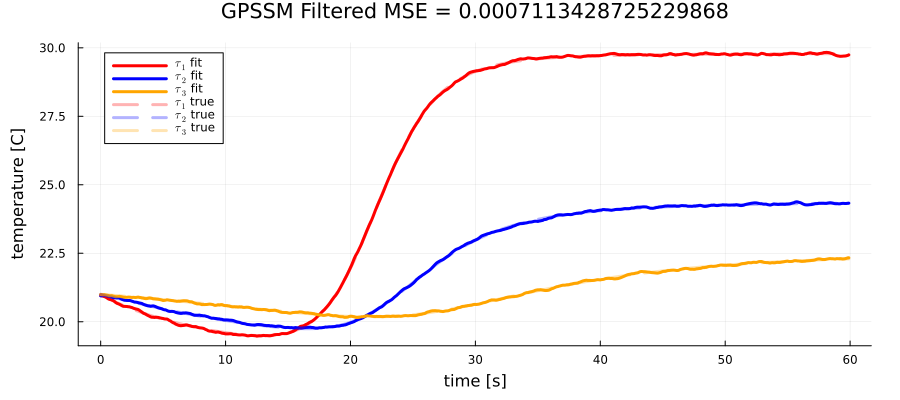

In [20]:
plot(tsteps,
     fitx_m[1:3,:]';
     ribbon=sqrt.(fitx_v[1:3,:])',
     legend = true, 
     title="GPSSM Filtered MSE = $FMSE_GPSSM",
     linecolors = ["red" "blue" "orange"], 
     fillcolors = ["red" "blue" "orange"], 
     labels = [L"$τ_1$ fit" L"$τ_2$ fit" L"$τ_3$ fit"],
     xlabel = "time [s]", 
     ylabel = "temperature [C]",
     size=(900,400)
)
plot!(tsteps, 
      transpose(states), 
      alpha = 0.3,
      linecolors = ["red" "blue" "orange"], 
      linestyle = :dash,
      labels = [L"$τ_1$ true" L"$τ_2$ true" L"$τ_3$ true"],
)


### Gaussian process fits over time

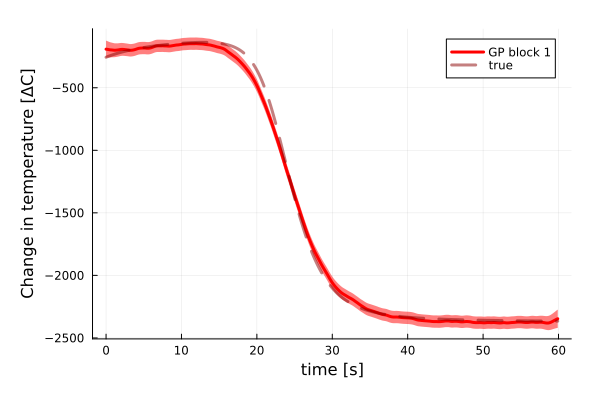

In [21]:
plot(tsteps,
     fitx_m[4,:];
     ribbon=sqrt.(fitx_v[4,:]),
     legend = true, 
     color = "red",
     labels = "GP block 1",
     xlabel = "time [s]", 
     ylabel = "Change in temperature [ΔC]",
     size=(600,400)
)
plot!(tsteps, pred_mean_block1.(states[1,:]), color="darkred", alpha=0.5, linestyle=:dash, label="true")

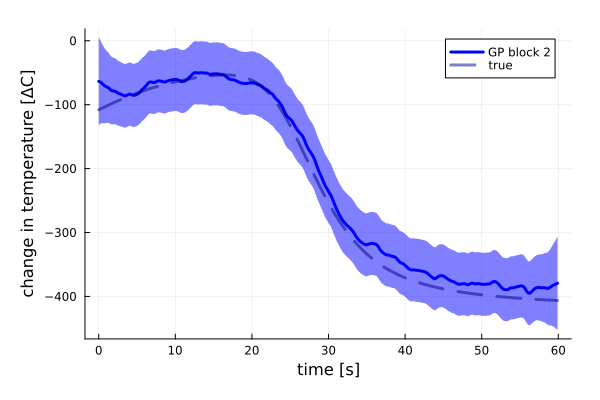

In [22]:
plot(tsteps,
     fitx_m[5,:],
     ribbon=sqrt.(fitx_v[5,:]),
     legend = true, 
     color = "blue",
     labels = "GP block 2",
     xlabel = "time [s]", 
     ylabel = "change in temperature [ΔC]",
     size=(600,400)
)
plot!(tsteps, pred_mean_block2.(states[2,:]), color="darkblue", alpha=0.5, linestyle=:dash, label="true")

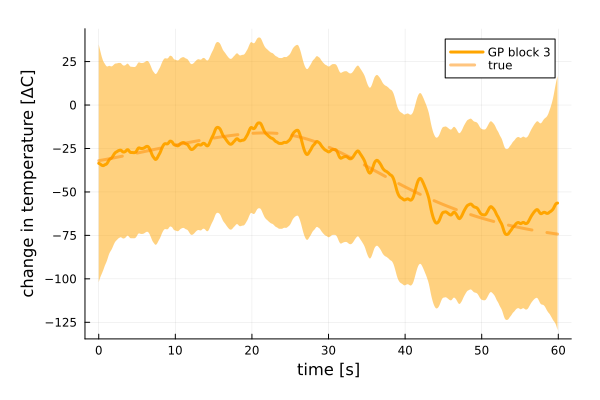

In [23]:
plot(tsteps,
     fitx_m[6,:],
     ribbon=sqrt.(fitx_v[6,:]),
     legend = true, 
     color = "orange",
     labels = "GP block 3",
     xlabel = "time [s]", 
     ylabel = "change in temperature [ΔC]",
     size=(600,400)
)
plot!(tsteps, pred_mean_block3.(states[3,:]), color="darkorange", alpha=0.5, linestyle=:dash, label="true")

### Extract nonlinearity

In [24]:
n_samples = 5
deg = 3

yls = [-0.5, 0.05]
xls = [285, 296]

samples_z1 = cat([rand(Normal(fitx_m[1,k],sqrt.(fitx_v[1,k])), n_samples) for k in 1:T]...,dims=2)
samples_z2 = cat([rand(Normal(fitx_m[2,k],sqrt.(fitx_v[2,k])), n_samples) for k in 1:T]...,dims=2)
samples_z3 = cat([rand(Normal(fitx_m[3,k],sqrt.(fitx_v[3,k])), n_samples) for k in 1:T]...,dims=2)
samples_f1 = cat([rand(Normal(fitx_m[4,k],sqrt.(fitx_v[4,k])), n_samples) for k in 1:T]...,dims=2)
samples_f2 = cat([rand(Normal(fitx_m[5,k],sqrt.(fitx_v[5,k])), n_samples) for k in 1:T]...,dims=2)
samples_f3 = cat([rand(Normal(fitx_m[6,k],sqrt.(fitx_v[6,k])), n_samples) for k in 1:T]...,dims=2)

5×600 Matrix{Float64}:
    6.60116   -40.3086    91.3106  …   -29.5004    -66.9332     -4.18954
 -148.079      10.1042   -34.6173     -149.882       3.00982   -92.2984
 -163.598      21.2847  -105.536        23.7256   -113.347      -9.72623
 -114.669    -124.649     49.777        -5.32815  -116.681     -67.3629
  -60.49      -57.3593   116.263        60.3188   -146.67     -137.82

In [25]:
f1_pol3 = Polynomials.fit(Polynomial{Float64}, fitx_m[1,:], fitx_m[4,:], deg)

Polynomial(17746.618983671608 - 2295.5191603148937*x + 101.6256324190745*x^2 - 1.5857596095174136*x^3)

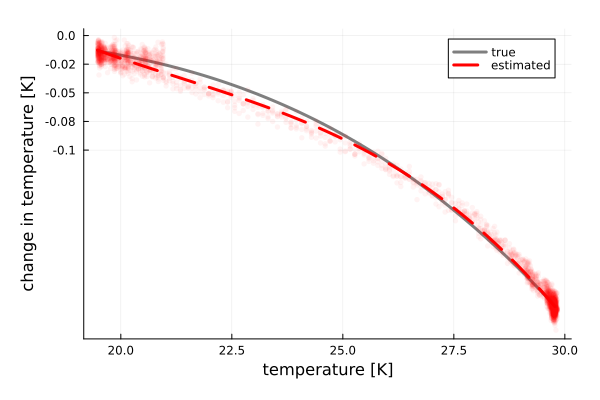

In [26]:
plot(xlabel="temperature [K]",
     ylabel="change in temperature [K]",
     yticks=(range(-1000,stop=0.0, length=5), round.(range(-1000,stop=0.0, length=5).*Δt./true_mcp_1, digits=2)),
     # ylims=(-1000,0)
     )
plot!(states[1,:], r.(states[1,:],1,true_τ_a), color="black", alpha=0.5, label="true")
scatter!(fitx_m[1,:], samples_f1', alpha=0.05, markerstrokewidth=0, markersize=3, color="red")
plot!(sort(fitx_m[1,:]), x -> f1_pol3(x), color="red", linestyle=:dash, label="estimated")

In [27]:
savefig("figures/VL+GPASSM-block1_fnest.png")

"/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/sioux/sysid-thermal/CCTA2024-BIDconvection/experiment-simulated/figures/VL+GPASSM-block1_fnest.png"

In [28]:
f2_pol3 = Polynomials.fit(fitx_m[2,:], fitx_m[5,:], deg)

Polynomial(-7482.118172998874 + 865.707168327793*x - 29.97082376739943*x^2 + 0.2619153976357527*x^3)

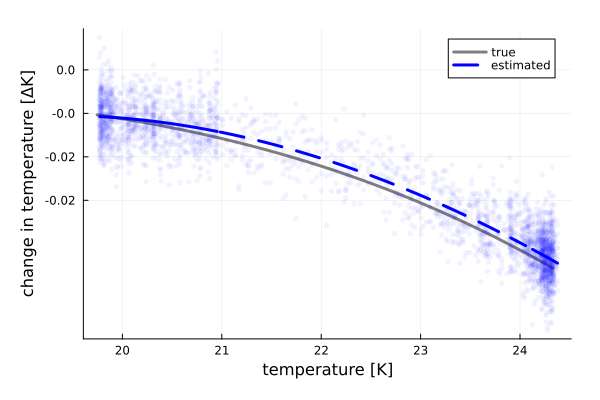

In [29]:
plot(xlabel="temperature [K]",
     ylabel="change in temperature [ΔK]",
     yticks=(range(-250,stop=50., length=4), round.(range(-250,stop=50., length=4).*Δt./true_mcp_2, digits=2)),
     # ylims=(-250,50),
     )
plot!(states[2,:], r.(states[2,:],2,true_τ_a), color="black", alpha=0.5, label="true")
scatter!(fitx_m[2,:], samples_f2', alpha=0.05, markerstrokewidth=0, markersize=3, color="blue")
plot!(fitx_m[2,:], x -> f2_pol3(x), color="blue", linestyle=:dash, label="estimated")

In [30]:
savefig("figures/VL+GPASSM-block2_fnest.png")

"/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/sioux/sysid-thermal/CCTA2024-BIDconvection/experiment-simulated/figures/VL+GPASSM-block2_fnest.png"

In [31]:
f3_pol3 = Polynomials.fit(fitx_m[3,:], fitx_m[6,:], deg)

Polynomial(-79841.76691072977 + 11289.447194130897*x - 530.8849021131809*x^2 + 8.298351351977145*x^3)

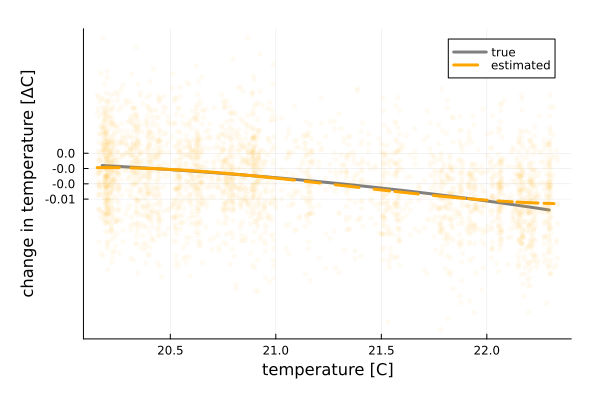

In [32]:
plot(xlabel="temperature [C]",
     ylabel="change in temperature [ΔC]",
     yticks=(range(-60,stop=0., length=4), round.(range(-60,stop=0, length=4).*Δt./true_mcp_3, digits=2)),
     # ylims=(-60, 0.),
     )
plot!(states[3,:], r.(states[3,:],3,true_τ_a), color="black", alpha=0.5, label="true")
scatter!(fitx_m[3,:], samples_f3', alpha=0.05, markerstrokewidth=0, markersize=3, color="orange")
plot!(fitx_m[3,:], x -> f3_pol3(x), color="orange", linestyle=:dash, label="estimated")

In [33]:
savefig("figures/VL+GPASSM-block3_fnest.png")

"/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/sioux/sysid-thermal/CCTA2024-BIDconvection/experiment-simulated/figures/VL+GPASSM-block3_fnest.png"

## Model validation

### Simulation with true function to generate validation data

In [34]:
N_val = 1000
tsteps_val = range(0.0, step=Δt, length=N_val)

t_onset_val = 30.
β = 0.5

# Generate functions
u1_val(t) = u.(t, true_b[1], t_onset_val, i=1, β=β)
u2_val(t) = u.(t, true_b[2], t_onset_val, i=2, β=β)
u3_val(t) = u.(t, true_b[3], t_onset_val, i=3, β=β)

inputs_val = hcat([[u1_val(k); u2_val(k); u3_val(k)] for k in tsteps_val]...)

3×1000 Matrix{Float64}:
 0.000917707  0.000964758  0.00101422  …  3000.0  3000.0  3000.0  3000.0
 0.0          0.0          0.0               0.0     0.0     0.0     0.0
 0.0          0.0          0.0               0.0     0.0     0.0     0.0

In [35]:
function NONLCONV_val(dz, z, params, t)
    "Lumped-element model with nonlinear convection term"

    # Extract parameters
    mcp_1, mcp_2, mcp_3, a_1, a_2, a_3, τ_a, k12, k23, h_a = params
    
    # Conduction
    dz[1] = (-k12*z[1] +      k12 *z[2]            ) / mcp_1
    dz[2] = ( k12*z[1] - (k12+k23)*z[2] + k23 *z[3]) / mcp_2
    dz[3] = (                 k23 *z[2] - k23 *z[3]) / mcp_3
    
    # Convection - linear
    dz[1] += h_a * a_1 * (τ_a - z[1]) / mcp_1
    dz[2] += h_a * a_2 * (τ_a - z[2]) / mcp_2
    dz[3] += h_a * a_3 * (τ_a - z[3]) / mcp_3
    
    # Convection - nonlinear
    dz[1] += pred_mean_block1(z[1]) ./ mcp_1
    dz[2] += pred_mean_block2(z[2]) ./ mcp_2
    dz[3] += pred_mean_block3(z[3]) ./ mcp_3
    
    # Input heat
    dz[1] += u1_val(t) / mcp_1
    dz[2] += u2_val(t) / mcp_2
    dz[3] += u3_val(t) / mcp_3
end

NONLCONV_val (generic function with 1 method)

In [36]:
sysparams = [true_mcp_1, 
             true_mcp_2, 
             true_mcp_3, 
             true_a_1, 
             true_a_2, 
             true_a_3, 
             true_τ_a, 
             true_k12, 
             true_k23, 
             true_h_a]

τ0_val = [20., 20.5, 21.]
sys_NONLCONV = ODEProblem(NONLCONV_val, τ0_val, (tsteps_val[1], tsteps_val[end]), sysparams)
states_val = Array(solve(sys_NONLCONV, RK4(); saveat=tsteps_val, verbose = true))

measurements_val = states_val + cholesky(true_R).L*randn(size(states_val))

3×1000 Matrix{Float64}:
 19.9977  20.0693  20.0184  20.0975  …  29.7078  29.8708  29.7188  29.7527
 20.64    20.6098  20.3658  20.608      24.2434  24.3269  24.2893  24.4041
 21.0884  20.9263  21.2138  21.0061     22.5733  22.31    22.5771  22.2445

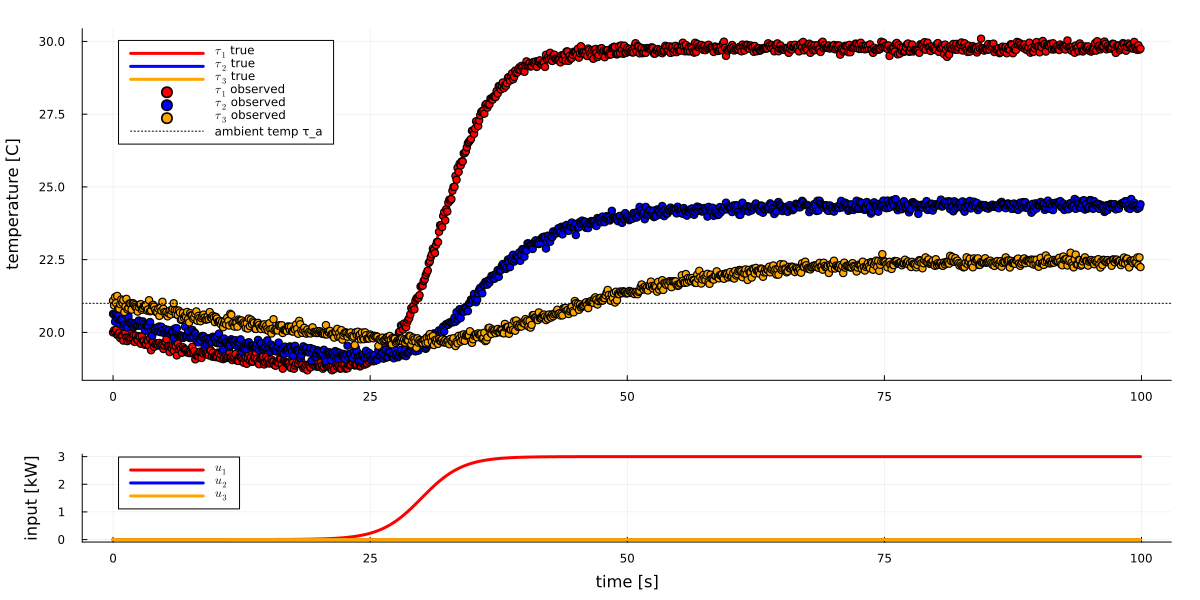

In [37]:
p101 = plot(xlabel="", ylabel="temperature [C]")
plot!(tsteps_val, states_val', linecolors = ["red" "blue" "orange"], labels = [L"$τ_1$ true" L"$τ_2$ true" L"$τ_3$ true"], )
scatter!(tsteps_val, measurements_val', markercolors = ["red" "blue" "orange"], labels = [L"$τ_1$ observed" L"$τ_2$ observed" L"$τ_3$ observed"])
hline!([true_τ_a], color="black", linewidth=1, linestyle=:dot, label="ambient temp τ_a")

p102 = plot(xlabel = "time [s]", ylabel = "input [kW]")
plot!(tsteps_val, inputs_val' ./ 1000, linecolors = ["red" "blue" "orange"], labels = [L"$u_1$" L"$u_2$" L"$u_3$"], )

plot(p101, p102, layout=grid(2,1, heights=[0.8, 0.2]), size=(1200,600))

### Simulation by identified model

In [38]:
function NONLCONV_idsim(dz, z, params, t)
    "Lumped-element model with nonlinear convection term"

    # Extract parameters
    mcp_1, mcp_2, mcp_3, a_1, a_2, a_3, τ_a, k12, k23, h_a = params
    
    # Conduction
    dz[1] = (-k12*z[1] +      k12 *z[2]            ) / mcp_1
    dz[2] = ( k12*z[1] - (k12+k23)*z[2] + k23 *z[3]) / mcp_2
    dz[3] = (                 k23 *z[2] - k23 *z[3]) / mcp_3
    
    # Convection - linear
    dz[1] += h_a * a_1 * (τ_a - z[1]) / mcp_1
    dz[2] += h_a * a_2 * (τ_a - z[2]) / mcp_2
    dz[3] += h_a * a_3 * (τ_a - z[3]) / mcp_3
    
    # Convection - nonlinear
    dz[1] += f1_pol3(z[1]) ./ mcp_1
    dz[2] += f2_pol3(z[2]) ./ mcp_2
    dz[3] += f3_pol3(z[3]) ./ mcp_3
    
    # Input heat
    dz[1] += u1_val(t) / mcp_1
    dz[2] += u2_val(t) / mcp_2
    dz[3] += u3_val(t) / mcp_3
end

idNONLCONV = ODEProblem(NONLCONV_idsim, τ0_val, (tsteps_val[1], tsteps_val[end]), sysparams)
sim_states = Array(solve(idNONLCONV, Tsit5(); saveat=tsteps_val, verbose = true))

3×1000 Matrix{Float64}:
 20.0  19.9862  19.9726  19.9592  …  29.7976  29.798   29.7984  29.7988
 20.5  20.4906  20.4812  20.4719     24.4805  24.4806  24.4806  24.4806
 21.0  20.9942  20.9885  20.9827     22.7087  22.7094  22.7101  22.7108

### Compare true and identified 

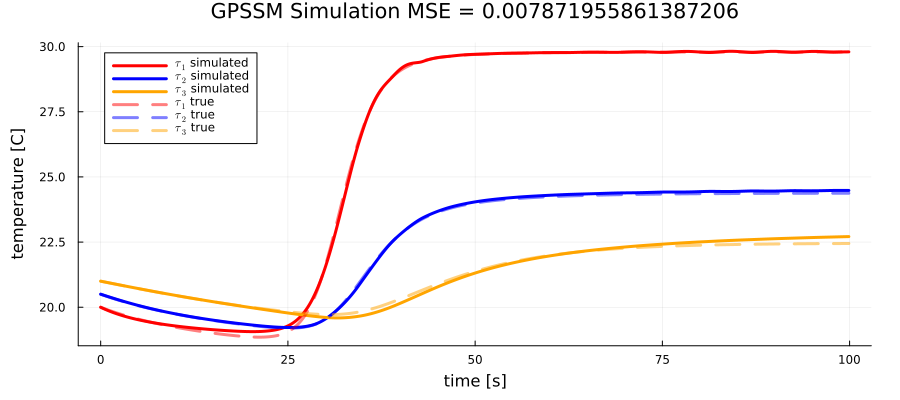

In [39]:
SMSE_GPSSM = mean((sim_states - states_val).^2)

plot(tsteps_val,
     sim_states';
     legend = true, 
     title = "GPSSM Simulation MSE = $SMSE_GPSSM",
     linecolors = ["red" "blue" "orange"], 
     fillcolors = ["red" "blue" "orange"], 
     labels = [L"$τ_1$ simulated" L"$τ_2$ simulated" L"$τ_3$ simulated"],
     xlabel = "time [s]", 
     ylabel = "temperature [C]",
     size=(900,400)
)
plot!(tsteps_val, 
      transpose(states_val), 
      alpha = 0.5,
      linecolors = ["red" "blue" "orange"], 
      linestyle = :dash,
      labels = [L"$τ_1$ true" L"$τ_2$ true" L"$τ_3$ true"],
)


In [40]:
savefig("figures/NONLCONV_VL+GPASSM-simulations.png")

"/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/sioux/sysid-thermal/CCTA2024-BIDconvection/experiment-simulated/figures/NONLCONV_VL+GPASSM-simulations.png"